# ODE Quick Overview

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import plotly.graph_objects as go
import pandas as pd


### Defining an ODE

In [2]:

def ratio_dydt(y,t):
    dydt = -2*y*t + 5
    return dydt


### Preparing Time Points + Zero Condition

In [10]:
y0 = 0
t = np.linspace(0,10,20)
t2 = np.linspace(0,10,200)

### Solving ODE

In [11]:
y_points = odeint(ratio_dydt, y0, t)
y_more_precise = odeint(ratio_dydt, y0, t2)

### Plotting

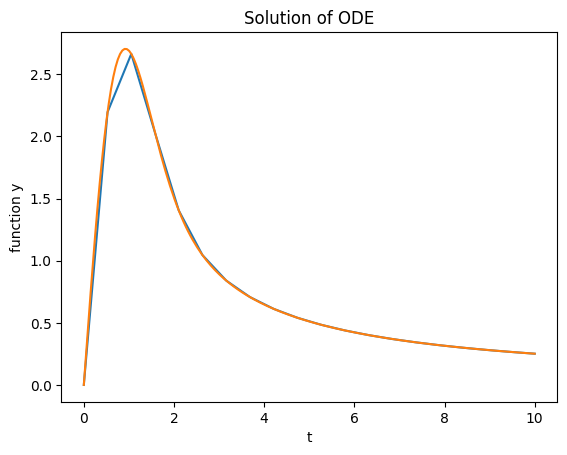

In [12]:
plt.plot(t, y_points, t2, y_more_precise)
plt.title("Solution of ODE")
plt.xlabel("t")
plt.ylabel("function y")
plt.show()

# Coupled Compartments

In [16]:
V_max = 3846
K_M = 874
k_e = 0.019

def ratio_dSdt(S,t):
    X_A, X_P = S
    absorption = V_max * X_A / (K_M + X_A)
    dXAdt = -absorption
    dXPdt = absorption - k_e * X_P
    return [dXAdt, dXPdt]

X_A_0 = 5000 # in milligrams
X_P_0 = 10 # baselines
S_0 = [X_A_0, X_P_0]

t = np.linspace(0,7,200)
solution = odeint(ratio_dSdt, y0=S_0, t=t)

X_P_sol = solution.T[1] # amount of creatine in plasma (mg)  
X_A_sol = solution.T[0] # amount of creatine in available in the gut (mg)  


### Gut and Plasma Creatine in [mg]

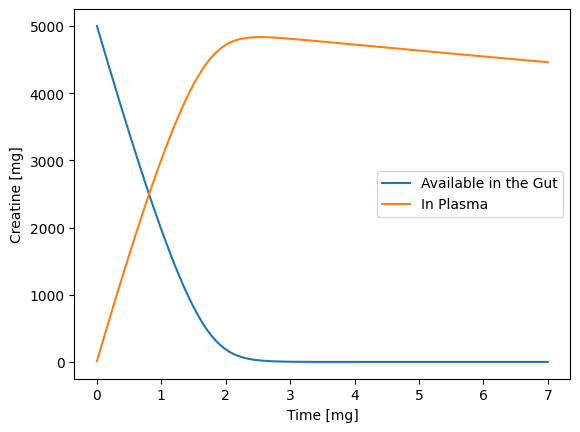

In [ ]:
plt.plot(t, X_A_sol, label='Available in the Gut')
plt.plot(t, X_P_sol, label='In Plasma')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Creatine [mg]')
plt.show()

### Plasma and Muscle Interstitial Concentration

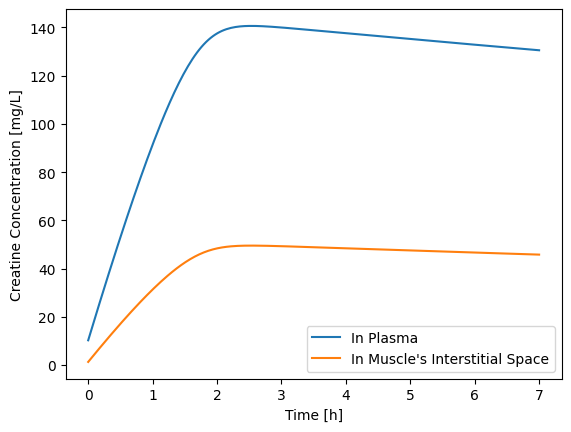

In [26]:
V_D = 37  # L
P_0 = 10   # baseline (mg/L)

C_P = X_P_sol / V_D + P_0 # plasma creatine concentration

F = 0.37 # penetration factor (no units; 0.37-0.47)
I0 = 1.2  # baseline interstitial creatine concentration mg/L
C_T = F * X_P_sol / V_D + I0 # muscle creatine concentration

plt.plot(t, C_P, label='In Plasma')
plt.plot(t, C_T, label='In Muscle\'s Interstitial Space')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Creatine Concentration [mg/L]')
plt.show()

### Including Muscle Compartment
Numerical starting guesses — maybe try, and then fit
- k_loss = 0.00072 h
- K_M_M ​= 100 mg/L (order-of-magnitude that brackets reported plasma concentrations)
- V_max_M = 500 mg/h (initial guess; gives ~12 g/day capacity if operating near Vmax — tune down/up)
    -> let's try to put ~30 mg/h

Initial parameters, some of which could be later refined:

In [63]:
V_max = 3846       # mg/h (gut absorption)
K_M = 874          # mg
V_D = 37           # L
CL = 9.07          # L/h
k_e = CL / V_D     # h^-1 ≈ 0.25

# V_max_M = 500      # mg/h (muscle uptake) REFINE!
# k_loss = 0.00096   # h^-1 (≈40-day half-life) REFINE!
K_M_M = 74        # mg/L (muscle MM constant) REFINE!

k_loss = np.log(2) / (40*24)   # t_half 40 dní
X_M_target = 160000           # mg, napr. 30 g
# V_max_M = k_loss * X_M_target   # ~29 mg/h
V_max_M = 200
# t_half_creatine_indays = 30
# k_loss = np.log(2) / (t_half_creatine_indays*24)  # 1/h, okolo 0.00096

### Initial conditions:

In [64]:
X_A_0 = 5000   # mg, one 5g oral dose
X_P_0 = 370      # mg in plasma
X_M_0 = 100000      # mg in muscle
S_0 = [X_A_0, X_P_0, X_M_0]

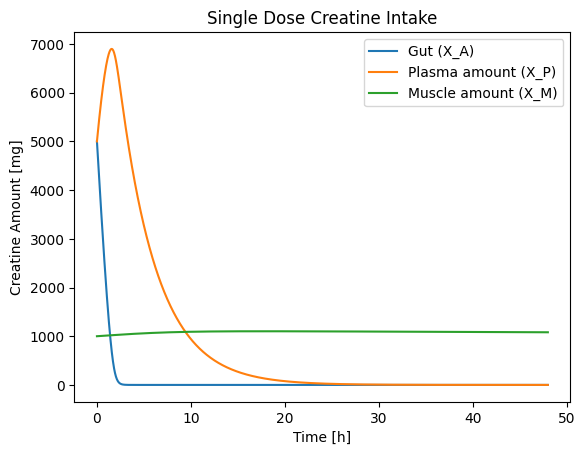

In [54]:
def creatine_model(S,t):
    X_A, X_P, X_M = S
    C_P = X_P / V_D  # mg/L
    absorption = V_max * X_A / (K_M + X_A)
    muscle_uptake = (V_max_M * C_P)/(K_M_M + C_P)
    dXAdt = - absorption
    dXPdt = absorption - k_e * X_P - muscle_uptake
    dXMdt = muscle_uptake - k_loss * X_M
    return [dXAdt, dXPdt, dXMdt]

S_0 = [X_A_0, X_P_0, X_M_0]

t = np.linspace(0,48,2000)
solution = odeint(creatine_model, y0=S_0, t=t)
X_A_sol, X_P_sol, X_M_sol = solution.T

plt.title('Single Dose Creatine Intake')
plt.plot(t, X_A_sol, label='Gut (X_A)')
plt.plot(t, X_P_sol, label='Plasma amount (X_P)')
plt.plot(t, X_M_sol, label='Muscle amount (X_M)')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Creatine Amount [mg]')
plt.show()

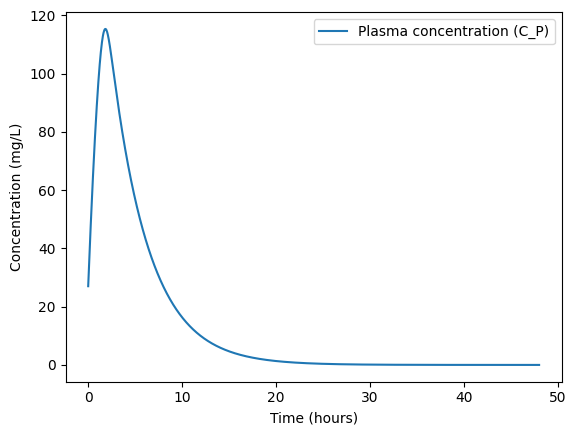

In [42]:
C_P = X_P_sol / V_D  # plasma concentration (mg/L)
plt.plot(t, C_P, label='Plasma concentration (C_P)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.legend()
plt.show()

### Multiple Doses

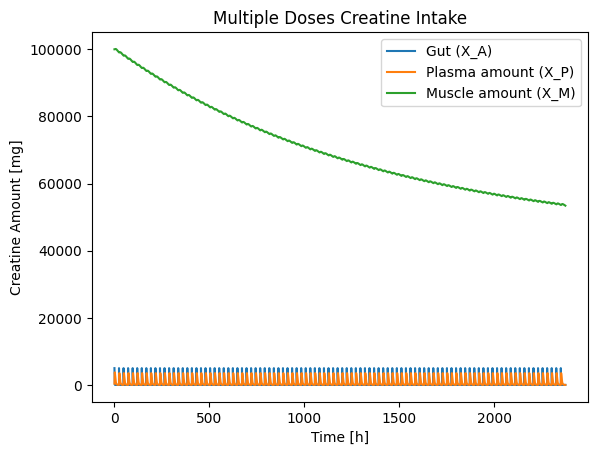

In [65]:
dose = 5000 # mg

def creatine_model(S,t):
    X_A, X_P, X_M = S
    C_P = X_P / V_D  # mg/L
    absorption = V_max * X_A / (K_M + X_A)
    muscle_uptake = (V_max_M * C_P)/(K_M_M + C_P)
    dXAdt = - absorption
    dXPdt = absorption - k_e * X_P - muscle_uptake
    dXMdt = muscle_uptake - k_loss * X_M
    return [dXAdt, dXPdt, dXMdt]

# Dose every 24h, 1000 steps in that time interval, we have 7 time intervals (7 days)

intervals = range(1,100)
concatenated_solution = []
concatenated_time = []

for interval in intervals:
    t = np.linspace((interval-1)*24, interval*24, 1000)
    if interval == 1:
        S_0 = [X_A_0, X_P_0, X_M_0]
    else:
        S_0 = [X_A_current[-1] + dose, X_P_current[-1], X_M_current[-1]]
    solution = odeint(creatine_model, y0=S_0, t=t)
    X_A_current, X_P_current, X_M_current = solution.T

    concatenated_time += list(t)
    concatenated_solution += list(zip(X_A_current, X_P_current, X_M_current))

concatenated_time = np.array(concatenated_time)
concatenated_solution = np.array(concatenated_solution)
X_A_sol, X_P_sol, X_M_sol = concatenated_solution.T

plt.title('Multiple Doses Creatine Intake')
plt.plot(concatenated_time, X_A_sol, label='Gut (X_A)')
plt.plot(concatenated_time, X_P_sol, label='Plasma amount (X_P)')
plt.plot(concatenated_time, X_M_sol, label='Muscle amount (X_M)')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Creatine Amount [mg]')
plt.show()

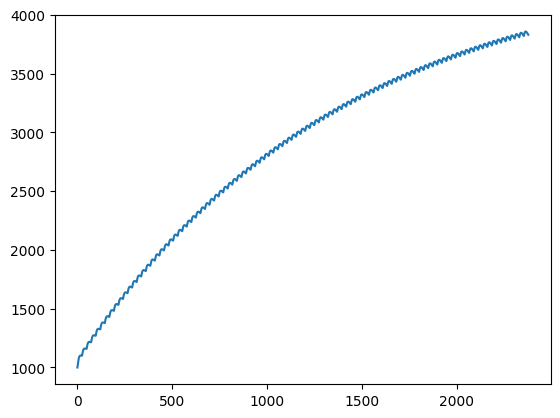

In [56]:
plt.plot(concatenated_time, X_M_sol, label='Muscle amount (X_M)')
plt.show()

In [34]:
# constants
mol_weight_creatine_mg_per_mmol = 131.13

# user/literature inputs
mmol_per_kg_DM_target = 165.0   # literat. plateau (mmol/kg dry mass)
dry_fraction = 0.25             # suchá hmota / mokrá hmota (odhad)
muscle_mass_kg = 0.40 * 70  # napr. 40% z hmotnosti
k_loss = np.log(2) / (40*24)    # t_half 40 dní

# convert to mg total
mmol_per_kg_wet = mmol_per_kg_DM_target * dry_fraction
mg_per_kg_wet = mmol_per_kg_wet * mol_weight_creatine_mg_per_mmol
X_M_target_mg = mg_per_kg_wet * muscle_mass_kg

print("X_M_target_mg:", X_M_target_mg, "mg (", X_M_target_mg/1000, "g )")

# desired average uptake (mg/h)
desired_avg_uptake = X_M_target_mg * k_loss

# mean_C_P from simulation (mg/L)
mean_C_P = np.mean(C_P_all)  # alebo z existujucich dat

# required Vmax_M
Vmax_needed = desired_avg_uptake * (K_M_M + mean_C_P) / mean_C_P
print("desired_avg_uptake [mg/h]:", desired_avg_uptake)
print("Vmax_needed [mg/h]:", Vmax_needed)


X_M_target_mg: 151455.15 mg ( 151.45515 g )
desired_avg_uptake [mg/h]: 109.35490646227457
Vmax_needed [mg/h]: 593.2094028469406


### Optimization of V_max_M

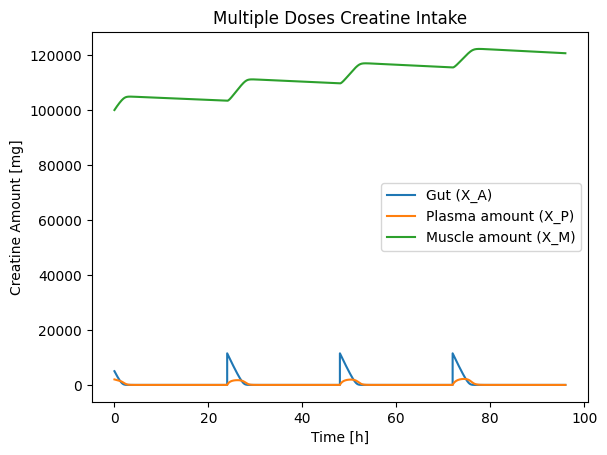

In [26]:
V_max = 3846       # mg/h (gut absorption)
K_M = 874          # mg
V_D = 27           # L (apparent volume of distribution) CHANGED, first it was 37 - that is in literature
CL = 15            # L/h CHANGED to better suite model, it was 9.07
k_e = CL / V_D     # plasma elimination rate [h^-1] ≈ 0.25
K_M_M = 74        # mg/L (muscle MM constant) REFINE!

k_loss = np.log(2) / (40*24)   # t_half 40 dní
# X_M_target = 125000           # mg, napr. 30 g
# V_max_M = k_loss * X_M_target   # ~29 mg/h
V_max_M = 12000
Cr_max = 150000  # mg, odhadnutá maximálna kapacita svalov

# Initial Conditions
X_A_0 = 5000   # mg, one 5g oral dose
X_P_0 = 2000     # mg in plasma
X_M_0 = 100000      # mg in muscle
S_0 = [X_A_0, X_P_0, X_M_0]

# Dosing and Model
dose_daily_food = 1500 # mg
dose = 10000 # mg

def creatine_model(S,t):
    X_A, X_P, X_M = S
    C_P = X_P / V_D  # mg/L
    absorption = V_max * X_A / (K_M + X_A)
    muscle_uptake = (V_max_M * C_P)/(K_M_M + C_P)
    # muscle_uptake *= (1 - X_M / Cr_max)  # slows down velocity when getting close to saturation, but too much...
    muscle_uptake *= (1 - (X_M / Cr_max)**1.5)
    dXAdt = - absorption
    # renal_clearance = 8  # L/h, pri saturácii 80% dávky
    # dXPdt = absorption - k_e * X_P - muscle_uptake - renal_clearance * C_P
    dXPdt = absorption - k_e * X_P - muscle_uptake
    dXMdt = muscle_uptake - k_loss * X_M
    return [dXAdt, dXPdt, dXMdt]

# Dose every 24h, 1000 steps in that time interval, we have 7 time intervals (7 days)

intervals = range(1,5)
concatenated_solution = []
concatenated_time = []

for interval in intervals:
    t = np.linspace((interval-1)*24, interval*24, 1000)
    if interval == 1:
        S_0 = [X_A_0, X_P_0, X_M_0]
    else:
        S_0 = [X_A_current[-1] + dose + dose_daily_food, X_P_current[-1], X_M_current[-1]]
    solution = odeint(creatine_model, y0=S_0, t=t)
    X_A_current, X_P_current, X_M_current = solution.T

    concatenated_time += list(t)
    concatenated_solution += list(zip(X_A_current, X_P_current, X_M_current))

concatenated_time = np.array(concatenated_time)
concatenated_solution = np.array(concatenated_solution)
X_A_sol, X_P_sol, X_M_sol = concatenated_solution.T

plt.title('Multiple Doses Creatine Intake')
plt.plot(concatenated_time, X_A_sol, label='Gut (X_A)')
plt.plot(concatenated_time, X_P_sol, label='Plasma amount (X_P)')
plt.plot(concatenated_time, X_M_sol, label='Muscle amount (X_M)')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Creatine Amount [mg]')
plt.show()

In [19]:
muscle_uptake = (V_max_M * C_P)/(K_M_M + C_P)
# Calibration
mol_weight = 131.13  # mg/mmol (molecular weight of creatine)

# scenario inputs (edit)
observed_gain_mg = 25000    # e.g. 25 g gained in muscle during loading
loading_days = 5
mean_C_P_during_loading = 80.0  # mg/L (estimate; increase with heavier loading)
K_M_M = 74.0  # mg/L (literature-ish)

# math
desired_avg_uptake = observed_gain_mg / (loading_days * 24.0)  # mg/h
Vmax_needed = desired_avg_uptake * (K_M_M + mean_C_P_during_loading) / mean_C_P_during_loading

print("Desired average uptake (mg/h):", desired_avg_uptake)
print("Estimated Vmax_M needed (mg/h):", Vmax_needed, "=> per day:", Vmax_needed*24/1000, "g/day")

NameError: name 'C_P' is not defined

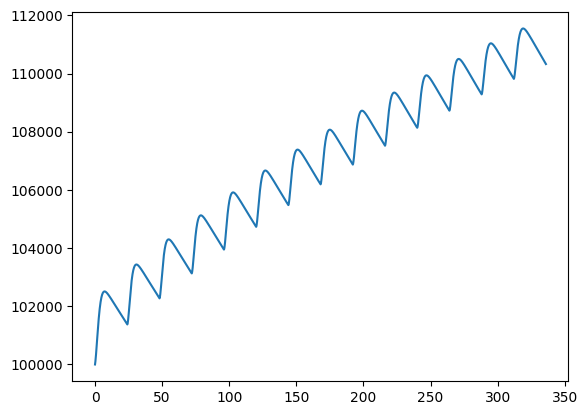

In [82]:
plt.plot(concatenated_time, X_M_sol, label='Muscle amount (X_M)')
plt.show()

# Creatine Concentration in Muscle

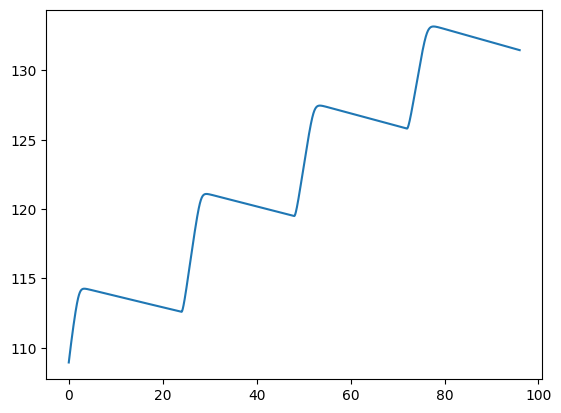

In [27]:
C_M_0 = 110     # mmol.kg-1 (baseline concentration of creatine)
weight = 70000     # g
M_AllMuscles = 0.25*0.4*weight # pre 70kg vahu, to je 7 kg, 7000g

MW_Cr = 131.13  # mg/mmol
M_AllMuscles_kg = M_AllMuscles / 1000  # 7000 g → 7 kg
C_M = X_M_sol / (MW_Cr * M_AllMuscles_kg)  # mmol/kg

plt.plot(concatenated_time, C_M, label='Concentration in Muscle (C_M [mmol.kg-1])')
plt.show()


In [29]:
# choose whether you work with wet or dry muscle mass
muscle_mass_wet_g = 30000.0  # napr. 20 kg wet
# literature Vmax example in nmol/min/g (wet)
nmol_per_min_per_g = 7.2

mw = 131.13  # g/mol
# convert nmol/min/g -> mg/h/g
mg_h_per_g = nmol_per_min_per_g * 1e-9 * mw * 60 * 1000

# total Vmax for whole muscle mass (mg/h)
V_max_M = mg_h_per_g * muscle_mass_wet_g

print("V_max_M (mg/h) from literature per-g:", V_max_M)

V_max_M (mg/h) from literature per-g: 1699.4448


# Adjustable Multi-Dosing Simulation

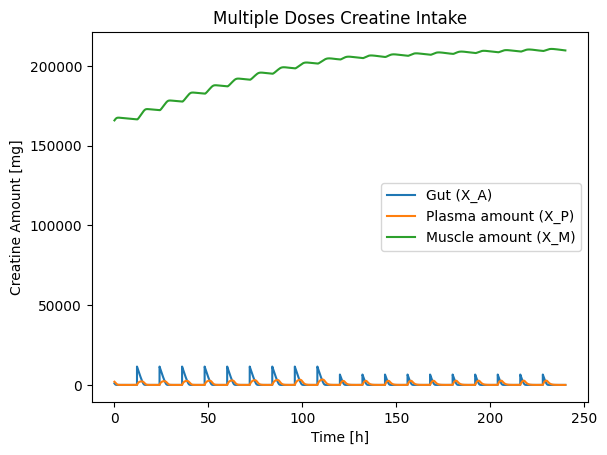

All dry muscles in kg: 11.5
Initial amount of creatine: 165879.44999999998


In [76]:
V_MAX = 3846       # mg/h (gut absorption)
K_M = 874          # mg
V_D = 27           # L (apparent volume of distribution) CHANGED, first it was 37 - that is in literature
CL = 15            # L/h CHANGED to better suite model, it was 9.07
k_e = CL / V_D     # plasma elimination rate [h^-1] ≈ 0.25
K_M_M = 74         # mg/L (muscle MM constant) REFINE!
k_loss = np.log(2) / (40*24) 

V_MAX_M = 10000     # mg/h, maximum muscle uptake rate, in literature just 1-3 mg/h
CR_MAX_PER_KG = 150       # mmol/kg dry, odhadnutá maximálna kapacita svalov

# INPUTS
TIME_OF_SIMULATION_IN_DAYS = 10                                     # INPUT; how long does the user want simulation
TIME_BETWEEN_DOSING = 12                                            # INPUT; hours between dosage           
TIME_END = 24 * TIME_OF_SIMULATION_IN_DAYS / TIME_BETWEEN_DOSING    # calculated based on INPUT; number of intervals
LOADING_PHASE = 5                                                   # INPUT; how many days does the user want loading phase
KEEPING_SATURATION_PHASE = TIME_OF_SIMULATION_IN_DAYS - LOADING_PHASE 
    # calculated based on INPUT; how many days in simulation rest for keeping the saturation
LOADING_END = int(24 * LOADING_PHASE / TIME_BETWEEN_DOSING)         # calculated based on INPUT; number of intervals with loading dose

LOADING_DOSE = 10000                                                # INPUT in mg; user can choose 10, 20 grams
KEEPING_DOSE = 5000                                                 # INPUT in mg; user can choose what dosage to keep saturation
DOSE_DAILY_FOOD = 1500                                              # mg

# INPUTS OF BODY
WEIGHT = 100                                                         # INPUT, in kg
DRY_FRACTION = 0.25                                                 # constant, dry fraction of wet muscle mass
ACTIVITY_LEVEL = 3                                                  # INPUT, in 1-3, 1=not very physically active, 3=athlete
SEX = "male"                                                        # INPUT, "female"/"male"

def calculate_muscle_fraction(activity_level, sex):
    if sex == "female":
        muscle_fraction = 0.28 + activity_level * 0.035
    if sex == "male":
        muscle_fraction = 0.31 + activity_level * 0.05
    return muscle_fraction

MUSCLE_FRACTION = calculate_muscle_fraction(ACTIVITY_LEVEL, SEX)    # calculated based on INPUT
M_ALL_MUSCLES_KG = DRY_FRACTION * MUSCLE_FRACTION * WEIGHT          # calculated based on INPUT, pre 70kg vahu, to je 7 kg, 7000g

C_M_0 = 110                                                         # mmol.kg-1 (baseline concentration of creatine)
MW_CR = 131.13                                                      # mg/mmol, molecular weight of creatine
CR_MAX = CR_MAX_PER_KG * MW_CR * M_ALL_MUSCLES_KG                   # calculated based on INPUT, mg

def calculate_initial_creatine_level(m_muscles):
    n = C_M_0 * M_ALL_MUSCLES_KG                                    # mmol amount that we need for this weight
    x_m_0 = n * MW_CR                                               # mg initial amount of creatine for this weight
    return x_m_0

# Initial Conditions
X_A_0 = 1000                                                # mg initially in gut
X_P_0 = 2000                                                # mg in plasma
X_M_0 = calculate_initial_creatine_level(M_ALL_MUSCLES_KG)  # mg in muscle
S_0 = [X_A_0, X_P_0, X_M_0]

def creatine_model(S,t):
    X_A, X_P, X_M = S
    C_P = X_P / V_D  # mg/L
    absorption = V_MAX * X_A / (K_M + X_A)
    muscle_uptake = (V_MAX_M * C_P)/(K_M_M + C_P)
    # muscle_uptake *= (1 - X_M / Cr_max)  # slows down velocity when getting close to saturation, but too much...
    muscle_uptake *= (1 - (X_M / CR_MAX)**1.5)
    dXAdt = - absorption
    # renal_clearance = 8  # L/h, pri saturácii 80% dávky
    # dXPdt = absorption - k_e * X_P - muscle_uptake - renal_clearance * C_P
    dXPdt = absorption - k_e * X_P - muscle_uptake
    dXMdt = muscle_uptake - k_loss * X_M
    return [dXAdt, dXPdt, dXMdt]

intervals = range(1, int(TIME_END) + 1)
concatenated_solution = []
concatenated_time = []

for interval in intervals:
    t = np.linspace((interval-1)*TIME_BETWEEN_DOSING, interval*TIME_BETWEEN_DOSING, 1000)
    if interval <= LOADING_END:
        dose = LOADING_DOSE
    else:
        dose = KEEPING_DOSE
    if interval == 1:
        S_0 = [X_A_0, X_P_0, X_M_0]
    else:
        S_0 = [X_A_current[-1] + dose + DOSE_DAILY_FOOD, X_P_current[-1], X_M_current[-1]]
    solution = odeint(creatine_model, y0=S_0, t=t)
    X_A_current, X_P_current, X_M_current = solution.T

    concatenated_time += list(t)
    concatenated_solution += list(zip(X_A_current, X_P_current, X_M_current))

concatenated_time = np.array(concatenated_time)
concatenated_solution = np.array(concatenated_solution)
X_A_sol, X_P_sol, X_M_sol = concatenated_solution.T

plt.title('Multiple Doses Creatine Intake')
plt.plot(concatenated_time, X_A_sol, label='Gut (X_A)')
plt.plot(concatenated_time, X_P_sol, label='Plasma amount (X_P)')
plt.plot(concatenated_time, X_M_sol, label='Muscle amount (X_M)')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Creatine Amount [mg]')
plt.show()

print(f"All dry muscles in kg: {M_ALL_MUSCLES_KG}")
print(f"Initial amount of creatine: {X_M_0}")

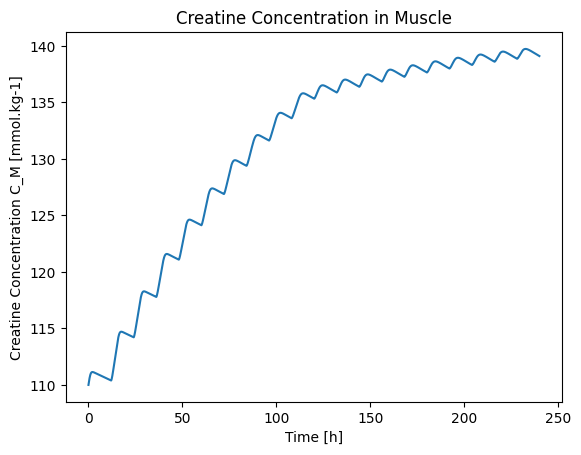

In [82]:
C_M = X_M_sol / (MW_CR * M_ALL_MUSCLES_KG)                              # mmol/kg concentration of creatine in body generally
plt.plot(concatenated_time, C_M, label='Creatine Concentration')
plt.xlabel('Time [h]')
plt.ylabel('Creatine Concentration C_M [mmol.kg-1]')
plt.title("Creatine Concentration in Muscle")
# plt.legend()
plt.show()
